# Introduction

### Project Abstract

### Figure illustrating workflow (Ruoyu)

See below for a brief summary illustration of the workflow for this project:

<img src="./img/workflow.jpg" width="1000">

# Data (Zhengyi)

Description: twitter sentiment analysis: detect attitude based on twitter text <br>
6 columns in raw dataset, only keep 3 for future analysis. 
- __target__: 0(negative) and 4(positive); 16,000,000 samples = 8,000,000 negative + 8,000,000 postive: balanced dataset. 
- id: id of the tweet, not informative, remove this column. 
- __date__: date that the twitter was posted, we __create 7 dummy variables, one for each weekday: "weekday_Mon, weekday_Tue, ..., weekday_Sun"__
- flag: all samples has the same value NO_QUERY, so remove this column. 
- username: the user who tweeted, like id, not informative, remove this column.
- __text__: the text of twitter, key components for creating feature spaces. 

# Pre-processing Pipeline

### Functions

In [7]:
import contractions
import my_globals
import numpy as np
import nltk
import pandas as pd
import re
import warnings

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from typing import List, Tuple

In [5]:
from preprocessing import tokenize

def del_username(s: str) -> str:
    """Delete @Username from a tweet str.

    :param s: input string
    :type s: str
    :rtype: str
    """

    return " ".join([t for t in tokenize(s, how="split") if not t.startswith("@")])

s = "BREAKING: Lions trading D'Andre Swift to Eagles. (via @RapSheet and @TomPelissero)"

print(s)
print(del_username(s))

BREAKING: Lions trading D'Andre Swift to Eagles. (via @RapSheet and @TomPelissero)
BREAKING: Lions trading D'Andre Swift to Eagles. (via and


In [8]:
def del_punc(s: str) -> str:
    """Delete punctuations from str.

    :param s: input string
    :type s: str
    :rtype: str
    """
    punc = my_globals.PUNCS
    return "".join([w for w in s if w not in punc])

s = "BREAKING: Lions trading D'Andre Swift to Eagles. (via @RapSheet and @TomPelissero)"

print(s)
print(del_punc(s))

BREAKING: Lions trading D'Andre Swift to Eagles. (via @RapSheet and @TomPelissero)
BREAKING Lions trading DAndre Swift to Eagles via @RapSheet and @TomPelissero


In [9]:
def del_link(s: str) -> str:
    """Delete links from str.

    :param s: input string
    :type s: str
    :rtype: str
    """
    r = r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)"
    return " ".join([re.sub(r, "", t) for t in tokenize(s, how="split")])

s = """
'BLADE', starring Mahershala Ali, Mia Goth and Delroy Lindo, is looking to begin filming in late May.
(Source: https://hollywoodreporter.com/movies/movie-news/marvels-blade-nabs-true-detective-creator-1235405915/)"
"""

print(s)
print(del_link(s))


'BLADE', starring Mahershala Ali, Mia Goth and Delroy Lindo, is looking to begin filming in late May.
(Source: https://hollywoodreporter.com/movies/movie-news/marvels-blade-nabs-true-detective-creator-1235405915/)"

'BLADE', starring Mahershala Ali, Mia Goth and Delroy Lindo, is looking to begin filming in late May. (Source: )"


In [10]:
def decontract(s: str) -> str:
    """Remove contractions in text.
    e.g. I'm -> I am; she'd -> she would

    :param s: input string
    :type s: str
    :rtype: str
    """
    tokens = []
    for t in tokenize(s, how="split"):
        tokens.append(contractions.fix(t))
    return " ".join(tokens)

s = "vanessa hudgens didn't go to coachella and now this.. what's next? mariah carey will not celebrate christmas?"

print(s)
print(decontract(s))

vanessa hudgens didn't go to coachella and now this.. what's next? mariah carey will not celebrate christmas?
vanessa hudgens did not go to coachella and now this.. what is next? mariah carey will not celebrate christmas?


In [13]:
def del_stopwords(s: str) -> str:
    """Delete stopwords and punctuation from a string.
    Note that the type-hinting indicates that this function ought
    to be run first in the pre-processing pipeline.

    :param s: input string
    :type s: str
    """
    stop_words = set(stopwords.words('english'))

    return " ".join([t for t in tokenize(s) if t not in stop_words])

s = "vanessa hudgens did not go to coachella and now this.. what is next? mariah carey will not celebrate christmas?"

print(s)
print(del_stopwords(s))

vanessa hudgens did not go to coachella and now this.. what is next? mariah carey will not celebrate christmas?
vanessa hudgens go coachella .. next ? mariah carey celebrate christmas ?


In [15]:
def remove_digits(s: str) -> bool:
    """Detect digits from str.

    :param s: input string
    :type s: str
    :rtype: bool
    """
    cleaned_string = re.sub(r'\w*\d\w*|[^\w\s]', '', s)
    cleaned_string = re.sub(r'\s+', ' ', cleaned_string)
    cleaned_string = cleaned_string.strip()

    return bool(cleaned_string)


def del_digits(s: str) -> str:
    """Delete digits from str.

    :param s: input string
    :type s: str
    :rtype: str
    """
    return " ".join([w for w in tokenize(s) if remove_digits(w)])

s = """
With the No. 128 overall pick in the 2023 @NFLDraft, the @RamsNFL select Stetson Bennett!
"""

print(s)
print(del_digits(s))


With the No. 128 overall pick in the 2023 @NFLDraft, the @RamsNFL select Stetson Bennett!

With the No overall pick in the NFLDraft the RamsNFL select Stetson Bennett


In [18]:
def lemmatize(s: str) -> str:
    """Lemmatize str.

    :param s: input string
    :type s: str
    :rtype: str
    """
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(t) for t in tokenize(s)])


s = """
Because we have the best workers in the world, we're going to have the strongest economy in the world.
"""

print(s)
print(lemmatize(s))


Because we have the best workers in the world, we're going to have the strongest economy in the world.

Because we have the best worker in the world , we 're going to have the strongest economy in the world .


In [19]:
def del_awww(s: str) -> str:
    """Delete repeated letters in a str.
    e.g. haaahaahaaaa -> haahaahaa

    :param s: input string
    :type s: str
    :rtype: str
    """
    pattern = r'(\w)\1{2,}'
    reduced_s = re.sub(pattern, r'\1\1', s)
    return reduced_s

s = "yayyyyyyy yayy"

print(s)
print(del_awww(s))

yayyyyyyy yayy
yayy yayy


### All together

In [21]:
from functools import reduce
pipeline_dict = {
    "del_link": del_link,
    "del_username": del_username,
    "decontract": decontract,
    "lemmatize": lemmatize,
    "del_stopwords": del_stopwords,
    "del_punc": del_punc,
    "del_digits": del_digits,
    "del_awww": del_awww
}


def preprocess_pipeline(
    s: str,
    return_lower: bool = True,
    pipeline: str = "conservative"
) -> str:
    """Run string through all pre-processing functions.

    :param s: input string
    :type s: str
    :param return_lower: whether to return lower case str or not
    :type return_lower: bool
    :param pipeline: style of pipelining. Either "conservative" or "aggresive".
    :type pipeline: str
    :rtype: str
    """
    if pipeline not in my_globals.PIPELINE.keys():
        warnings.warn(
            "Invalid pipeline. Default to 'conservative'."
        )
        pipeline = "conservative"

    # pipeline designs stored in my_globals
    s = reduce(
        lambda value, function: function(value),
        (
            pipeline_dict[key]
            for key in my_globals.PIPELINE[pipeline]
        ),
        s,
    )

    return s.lower() if return_lower else s

s = """
Seiji Tsukimoto is an artist who blends pop-up book and kirie techniques to create greeting cards and designs encapsulated within spherical frames without use of any glue
"""

t = preprocess_pipeline(s, return_lower=True, pipeline="conservative")
print(s)
print(t)


Seiji Tsukimoto is an artist who blends pop-up book and kirie techniques to create greeting cards and designs encapsulated within spherical frames without use of any glue

seiji tsukimoto artist blend popup book kirie technique create greeting card design encapsulated within spherical frame without use glue


# Feature Spaces

### TF-IDF

Term Frequency-Inverse Document Frequency(TF-IDF) is defined by 

\begin{align*}
    \text{TF}(t) &= \frac{\text{Occurence of term $t$ in document}}{\text{Total number of terms in document}}\\
    \text{IDF}(t) &= \log\left(
        \frac{
            \text{Total number of documents}
        }{
            \text{Number of documents containing term $t$}
        }
    \right)\\
    \text{TF-IDF}(t)&=\text{TF}(t)\cdot \text{IDF}(t)
\end{align*}

Intuition: Relative importance $\times$ relative offset

In [22]:
from utils import get_feature_space

demo_f1 = get_feature_space(
    N = 1000,
    feature_space=1,
    max_features=10,
    random_seed=4525
)

demo_f1

C:\Users\linru\AppData\Roaming\Python\Python39\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,exclaim_freq,mention_count,cap_freq,target,weekday_Mon,weekday_Tue,weekday_Wed,weekday_Thu,weekday_Fri,weekday_Sat,weekday_Sun,tfidf_day,tfidf_get,tfidf_go,tfidf_going,tfidf_good,tfidf_got,tfidf_like,tfidf_love,tfidf_wa,tfidf_work
0,0.0,1,0.101695,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0
1,0.0,1,0.078947,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0
2,0.0,0,0.028986,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0
3,0.0,10,0.222222,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
4,0.0,1,0.000000,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0,0.093750,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
996,0.0,1,0.030769,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.687996,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.725715,0.0
997,0.0,1,0.000000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.692598,0.0,0.0,0.0,0.0,0.721324,0.0,0.000000,0.0
998,0.0,0,0.148148,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


### Word2Vec (Mike)

Pre-trained in library vs. fit on own document

In [23]:
from utils import get_feature_space

demo_f2 = get_feature_space(
    N = 1000,
    feature_space=2,
    max_features=10,
    random_seed=4525
)

demo_f2

C:\Users\linru\AppData\Roaming\Python\Python39\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,exclaim_freq,mention_count,cap_freq,target,weekday_Mon,weekday_Tue,weekday_Wed,weekday_Thu,weekday_Fri,weekday_Sat,weekday_Sun,0,1,2,3,4,5,6,7,8,9
0,0.0,1,0.101695,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.425698,0.656093,0.055537,0.591616,0.120502,0.333190,0.322205,0.249077,0.827183,0.914529
1,0.0,1,0.078947,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.433069,0.675322,0.086407,0.476141,0.129918,0.334643,0.190001,0.204248,0.892071,0.916847
2,0.0,0,0.028986,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.432195,0.571778,0.041239,0.788095,0.156576,0.278325,0.517872,0.731983,0.822918,0.865297
3,0.0,10,0.222222,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.424415,0.765760,0.077409,0.096150,0.088386,0.298628,0.182869,0.113047,0.956757,0.874518
4,0.0,1,0.000000,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.387777,0.684490,0.361828,0.613221,0.092954,0.371385,0.138061,0.241088,0.894166,0.875149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0,0.093750,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.455166,0.409661,0.071957,0.608744,0.135676,0.267937,0.399963,0.168713,0.693614,0.745113
996,0.0,1,0.030769,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.444608,0.606586,0.063228,0.431978,0.120683,0.330497,0.388839,0.146115,0.951708,0.803855
997,0.0,1,0.000000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.414302,0.510702,0.112203,0.681278,0.071131,0.469217,0.318545,0.264870,0.788140,0.945978
998,0.0,0,0.148148,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.419373,0.701324,0.034955,0.646980,0.085039,0.295978,0.236462,0.507629,0.903342,0.939545


### Extra features

- `exclaim_freq`: frequency of exclamation points:

\begin{align*}
\text{exclaim_freq(document)} &= \frac{\text{Count("!")}}{\sum_{\text{term}\in \text{doc}}\text{len(term)}}\\
e.g.\quad \text{exclaim_freq("I! like apples!!")}
&=\frac{3}{2 + 4 + 8}
\end{align*}

- `mention_count`: count of occurrence of "@Username4525" in a document.

- `cap_freq`: frequency of capitalized letters:

\begin{align*}
\text{cap_freq(document)} &= \frac{\text{Count of CAPITALIZED letters}}{\text{len(document)}}\\
e.g.\quad \text{cap_freq("I LIKE APPLES'')}
&=1
\end{align*}

# Models Demo

In [24]:
import pandas as pd
import numpy as np

f1 = pd.read_csv("../project_data/feature_space_1.csv", encoding="latin1")
f2 = pd.read_csv("../project_data/feature_space_2.csv", encoding="latin1")

In [38]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
np.random.seed(4525)
df1 = f1.sample(5000)
df2 = f2.sample(5000)

X1 = df1.drop(['target'], axis=1)
y1 = df1['target']
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.1, random_state=4525)

X2 = df2.drop(['target'], axis=1)
y2 = df2['target']
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.1, random_state=4525)

def assess(y_true, y_pred, plot = False):
    print("confusion matrix:")
    conf_mat = confusion_matrix(y_true, y_pred)
    print(conf_mat)
    print()
    print("accuracy_score:")
    print(accuracy_score(y_true, y_pred))
    print()
    print("classification report:")
    print(classification_report(y_true,y_pred))
    print()

    if plot:
        fig, ax = plt.subplots(1,1, figsize = [7,7])
        sns.heatmap(
            confusion_matrix(y_true, y_pred, normalize="true"), 
            annot=True, fmt = ".3f", ax = ax, cmap="Blues")

    return conf_mat

### Naive Bayes

confusion matrix:
[[177  73]
 [ 53 197]]

accuracy_score:
0.748

classification report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       250
           4       0.73      0.79      0.76       250

    accuracy                           0.75       500
   macro avg       0.75      0.75      0.75       500
weighted avg       0.75      0.75      0.75       500




array([[177,  73],
       [ 53, 197]], dtype=int64)

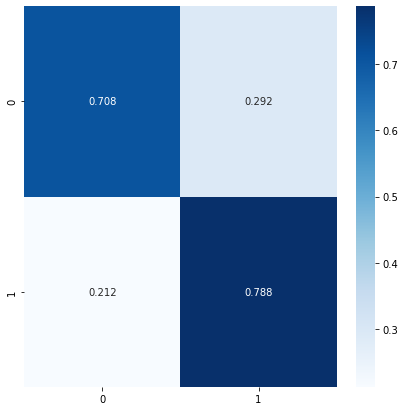

In [62]:
# feature space 1
model = BernoulliNB(alpha=1)
model.fit(X1_train, y1_train)
y_pred = model.predict(X1_test)
assess(y1_test, y_pred, plot=True)

confusion matrix:
[[180  85]
 [126 109]]

accuracy_score:
0.578

classification report:
              precision    recall  f1-score   support

           0       0.59      0.68      0.63       265
           4       0.56      0.46      0.51       235

    accuracy                           0.58       500
   macro avg       0.58      0.57      0.57       500
weighted avg       0.58      0.58      0.57       500




array([[180,  85],
       [126, 109]], dtype=int64)

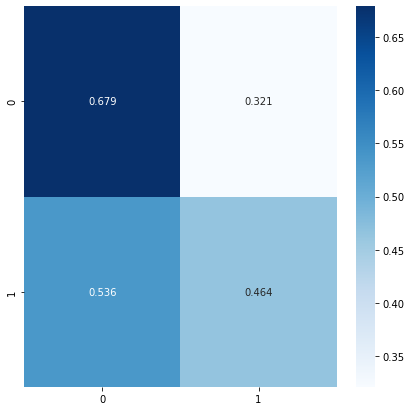

In [63]:
# feature space 2

model = BernoulliNB(alpha=1)
model.fit(X2_train, y2_train)
y_pred = model.predict(X2_test)
assess(y2_test, y_pred, plot=True)

### Logistic Regression

confusion matrix:
[[177  73]
 [ 50 200]]

accuracy_score:
0.754

classification report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       250
           4       0.73      0.80      0.76       250

    accuracy                           0.75       500
   macro avg       0.76      0.75      0.75       500
weighted avg       0.76      0.75      0.75       500




array([[177,  73],
       [ 50, 200]], dtype=int64)

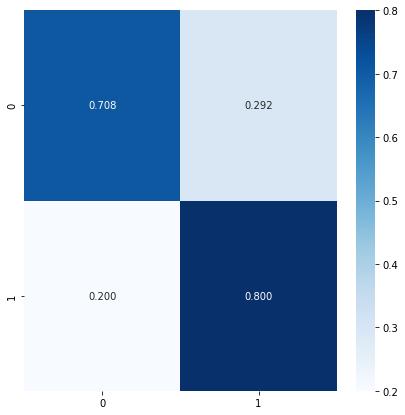

In [64]:
# feature space 1

model = LogisticRegression(C=1)
model.fit(X1_train, y1_train)
y_pred = model.predict(X1_test)
assess(y1_test, y_pred, plot=True)

c:\Users\linru\Anaconda3\envs\DL\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


confusion matrix:
[[193  72]
 [ 63 172]]

accuracy_score:
0.73

classification report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       265
           4       0.70      0.73      0.72       235

    accuracy                           0.73       500
   macro avg       0.73      0.73      0.73       500
weighted avg       0.73      0.73      0.73       500




array([[193,  72],
       [ 63, 172]], dtype=int64)

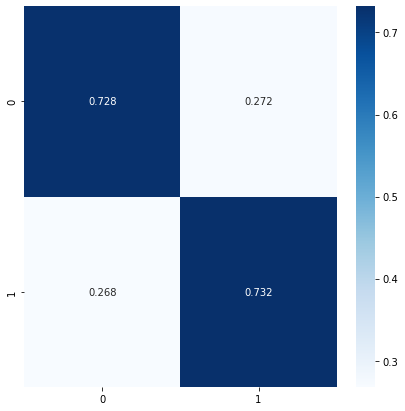

In [68]:
# feature space 2

model = LogisticRegression(penalty="l2")
model.fit(X2_train, y2_train)
y_pred = model.predict(X2_test)
assess(y2_test, y_pred, plot=True)

### Random Forest

confusion matrix:
[[168  82]
 [ 58 192]]

accuracy_score:
0.72

classification report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.71       250
           4       0.70      0.77      0.73       250

    accuracy                           0.72       500
   macro avg       0.72      0.72      0.72       500
weighted avg       0.72      0.72      0.72       500




array([[168,  82],
       [ 58, 192]], dtype=int64)

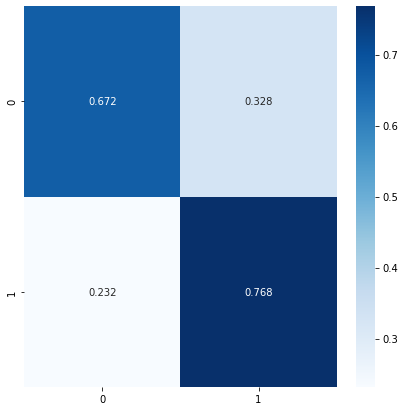

In [72]:
# feature space 1

model = RandomForestClassifier(max_depth=250, max_features='log2', n_estimators=800)
model.fit(X1_train, y1_train)
# save for demo feature importance
rf_model = model
y_pred = model.predict(X1_test)
assess(y1_test, y_pred, plot=True)

confusion matrix:
[[207  58]
 [ 72 163]]

accuracy_score:
0.74

classification report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       265
           4       0.74      0.69      0.71       235

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.74      0.74      0.74       500




array([[207,  58],
       [ 72, 163]], dtype=int64)

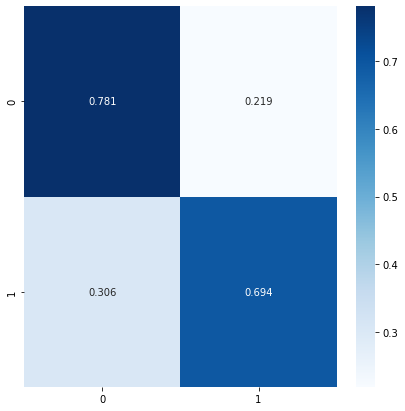

In [70]:
# feature space 2

model = RandomForestClassifier(max_depth=100, n_estimators=500)
model.fit(X2_train, y2_train)
y_pred = model.predict(X2_test)
assess(y2_test, y_pred, plot=True)

### LSTM (Zhengyi)

# Result and summary

### Best Performance Overall

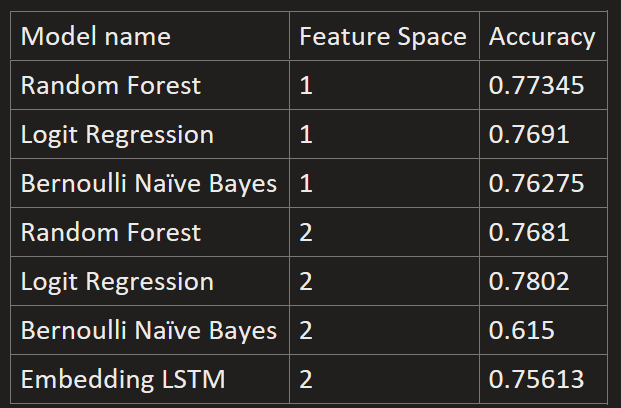

In [87]:
importances = rf_model.feature_importances_

n = 50
print(f"Most important {n} features (Descending order):")

most_important = list(X1.columns[np.argsort(-importances)][:n])
for id, item in enumerate(most_important):
    print(f"{id}: {item}")

Most important 50 features (Descending order):
0: cap_freq
1: mention_count
2: exclaim_freq
3: weekday_Thu
4: tfidf_love
5: tfidf_thanks
6: weekday_Wed
7: tfidf_good
8: tfidf_work
9: tfidf_sad
10: weekday_Mon
11: tfidf_want
12: weekday_Sun
13: tfidf_miss
14: tfidf_day
15: tfidf_go
16: tfidf_great
17: tfidf_sorry
18: weekday_Sat
19: tfidf_thank
20: tfidf_lol
21: tfidf_hate
22: tfidf_get
23: tfidf_going
24: tfidf_morning
25: tfidf_wa
26: weekday_Fri
27: tfidf_still
28: weekday_Tue
29: tfidf_you
30: tfidf_bad
31: tfidf_got
32: tfidf_wish
33: tfidf_like
34: tfidf_happy
35: tfidf_back
36: tfidf_feel
37: tfidf_today
38: tfidf_haha
39: tfidf_sleep
40: tfidf_know
41: tfidf_new
42: tfidf_one
43: tfidf_twitter
44: tfidf_see
45: tfidf_really
46: tfidf_nice
47: tfidf_missed
48: tfidf_my
49: tfidf_night
